## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text

%matplotlib inline

In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('./data/airbnb_data/AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [3]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

df_train, df_val  = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df_train), len(df_val), len(df_test)

(29337, 9779, 9779)

In [4]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [5]:
y_train = np.log1p(df_train['price'])
y_val = np.log1p(df_val['price'])
y_test = np.log1p(df_test['price'])

In [6]:
del df_train['price']
del df_val['price']
del df_test['price']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [7]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [8]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [9]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [10]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Which feature is used for splitting the data?

* **`room_type`**
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [11]:
rf = RandomForestRegressor(
    n_estimators=10,
    random_state=1,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [12]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val= dv.transform(val_dicts)

In [13]:
y_pred = rf.predict(X_val)

In [14]:
mean_squared_error(y_val, y_pred, squared=False)

0.4598535778342608

What's the RMSE of this model on validation?

* 0.059
* 0.259
* **0.459**
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [15]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(
        n_estimators=n,
        random_state=1,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    scores.append((n, rmse))

In [16]:
df_scores = pd.DataFrame(scores, columns =['n_estimators', 'rmse'])

In [17]:
df_scores

,n_estimators,rmse
0,10,0.459854
1,20,0.447831
2,30,0.445120
3,40,0.443225
4,50,0.442231
5,60,0.441535
6,70,0.440867
7,80,0.440763
8,90,0.440244
9,100,0.439783


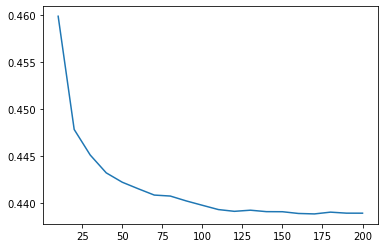

In [18]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- **120**

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [25]:
scores = []

for m_depth in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(
            n_estimators=n,
            random_state=1,
            max_depth=m_depth,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        scores.append((n, m_depth, rmse))

In [26]:
df_scores = pd.DataFrame(scores, columns =['n_estimators', 'max_depth', 'rmse'])

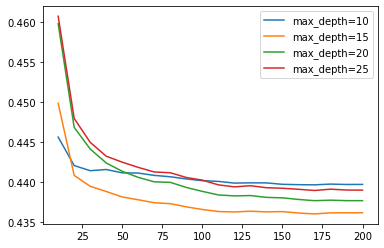

In [28]:
for m_depth in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == m_depth]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label='max_depth=%d' % m_depth)

plt.legend()

What's the best `max_depth`:

* 10
* **15**
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

**No**

In [43]:
def get_scores_df(random_seed):
    scores = []

    for m_depth in [10, 15, 20, 25]:
        for n in range(10, 201, 10):
            rf = RandomForestRegressor(
                n_estimators=n,
                random_state=random_seed,
                max_depth=m_depth,
                n_jobs=-1
            )
            rf.fit(X_train, y_train)

            y_pred = rf.predict(X_val)
            rmse = mean_squared_error(y_val, y_pred, squared=False)
            scores.append((n, m_depth, rmse))
    
    return pd.DataFrame(scores, columns =['n_estimators', 'max_depth', 'rmse'])

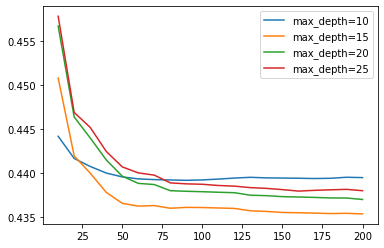

In [44]:
# Random seed = 10
df_subset_rs_10 = get_scores_df(10)

for m_depth in [10, 15, 20, 25]:
    df_subset = df_subset_rs_10[df_subset_rs_10.max_depth == m_depth]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label='max_depth=%d' % m_depth)

plt.legend()

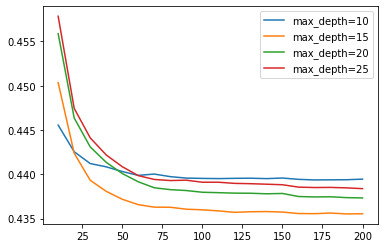

In [45]:
# Random seed = 50
df_subset_rs_50 = get_scores_df(50)

for m_depth in [10, 15, 20, 25]:
    df_subset = df_subset_rs_50[df_subset_rs_50.max_depth == m_depth]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label='max_depth=%d' % m_depth)

plt.legend()

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [33]:
rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [34]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val= dv.transform(val_dicts)

In [35]:
feature_importance = []
for feat, importance in zip(df_val.columns, rf.feature_importances_):
    feature_importance.append((feat, importance))
    
pd.DataFrame(feature_importance, columns=['feature', 'importance']).sort_values(by='importance', ascending=False)

,feature,importance
3,room_type,0.153476
2,longitude,0.151756
0,neighbourhood_group,0.076566
4,minimum_nights,0.053170
7,calculated_host_listings_count,0.034044
1,latitude,0.030264
6,reviews_per_month,0.001115
8,availability_365,0.001034
5,number_of_reviews,0.000447


What's the most important feature? 

* `neighbourhood_group=Manhattan`
* **`room_type=Entire home/apt`**
* `longitude`
* `latitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [36]:
!pip install XGBoost

     |████████████████████████████████| 173.5 MB 18 kB/s              


In [37]:
import xgboost as xgb

In [38]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [53]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

In [41]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [46]:
y_pred = model.predict(dval)

In [47]:
rmse = mean_squared_error(y_val, y_pred, squared=False)
rmse

0.43621034591295677

Now change `eta` first to `0.1` and then to `0.01`

In [57]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

In [58]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [59]:
y_pred = model.predict(dval)

In [60]:
rmse = mean_squared_error(y_val, y_pred, squared=False)
rmse

0.43249655247991464

In [61]:
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

In [62]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [63]:
y_pred = model.predict(dval)

In [64]:
rmse = mean_squared_error(y_val, y_pred, squared=False)
rmse

1.630452438951798

What's the best eta?

* 0.3
* **0.1**
* 0.01

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

